## Demo: MultiContainer with two sequential ShiftAmountActivities
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

In certain scenarios it is important to distinguish which types of objects are available in a container. HasContainer does not provide this capability, while MultiContainer does. 

A MultiContainer represents a named set of containers. The number of allowed containers is limited by parameter **store_capacity**.

For each container a name (**id_** property), a **capacity** and **level** is specified. 

A MultiContainer can be initialized with parameter **initials** as provided in the example for site and vessel configuration below.

In this example two ShiftAmountActivities are packed in a SequentialActivity, loading one piece of 'Cargo type 1' and one pieve of 'Cargo type 2' form 'from_site' to 'vessel01'.

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasMultiContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.MultiContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

The clas HasContainer has now been replaced with HasMultiContainer. The **from_site** can contain four different container types, but right now contains only two: One called 'Cargo type 1' with a capacity of 10 and a level of 2 and one called 'Cargo type 2' with a capacity of 2 and a level of 0.

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "store_capacity": 4,
                  "initials": [
                                  {"id": "Cargo type 1", "level": 10, "capacity": 10},
                                  {"id": "Cargo type 2", "level": 5, "capacity": 5},
                              ],
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

##### 3.2. Create vessel object(s)

The class ContainerDependentMovable has been replaced with MultiContainerDependentMovable. The vessel has two containers, one for 'Cargo type 1' and one for 'Cargo type 2', each with a capacity of two and a current level of zero.

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 1,
                 "unloading_rate": 1,
                 "store_capacity": 4,
                 "initials": [
                                {"id": "Cargo type 1", "level": 0, "capacity": 2},
                                {"id": "Cargo type 2", "level": 0, "capacity": 2},
                             ],
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

## ShiftAmount Activity for MultiContainer
The **amount** specifies the objects to be transfered and the **id_** parameter specifies to which container this activity relates.

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of the sub processes and include reporting_activity
sub_processes = [
    model.ShiftAmountActivity(
        env=my_env,
        name="Transfer cargo type 1",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=1,
        id_="Cargo type 1",
        duration=20,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Transfer cargo type 2",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=1,
        id_="Cargo type 2",
        duration=40,
    )
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
    env=my_env,
    name="Sequential activity of basic activities",
    registry=registry,
    sub_processes=sub_processes,
)

#### 4. Register processes and run simpy

In [8]:
# initate the simpy processes defined in the 'sub processes' and run simpy
model.register_processes(sequential_activity)
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [9]:
display(plot.get_log_dataframe(vessel01, [*sub_processes]))

,Activity,Timestamp,ActivityState,geometry,container level
0,Transfer cargo type 1,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),"{'Cargo type 1': 0, 'Cargo type 2': 0}"
1,Transfer cargo type 1,1970-01-01 00:00:20,STOP,POINT (4.18055556 52.18664444),"{'Cargo type 2': 0, 'Cargo type 1': 1}"
2,Transfer cargo type 2,1970-01-01 00:00:20,START,POINT (4.18055556 52.18664444),"{'Cargo type 2': 0, 'Cargo type 1': 1}"
3,Transfer cargo type 2,1970-01-01 00:01:00,STOP,POINT (4.18055556 52.18664444),"{'Cargo type 1': 1, 'Cargo type 2': 1}"


In [10]:
display(plot.get_log_dataframe(from_site, [*sub_processes]))

,Activity,Timestamp,ActivityState,container level,geometry
0,Transfer cargo type 1,1970-01-01 00:00:00,START,"{'Cargo type 1': 10, 'Cargo type 2': 5}",POINT (4.18055556 52.18664444)
1,Transfer cargo type 1,1970-01-01 00:00:20,STOP,"{'Cargo type 2': 5, 'Cargo type 1': 9}",POINT (4.18055556 52.18664444)
2,Transfer cargo type 2,1970-01-01 00:00:20,START,"{'Cargo type 2': 5, 'Cargo type 1': 9}",POINT (4.18055556 52.18664444)
3,Transfer cargo type 2,1970-01-01 00:01:00,STOP,"{'Cargo type 1': 9, 'Cargo type 2': 4}",POINT (4.18055556 52.18664444)


##### 5.2 Visualise gantt charts

In [11]:
plot.get_gantt_chart([sequential_activity, vessel01, *sub_processes])

##### 5.3 Visualise step charts

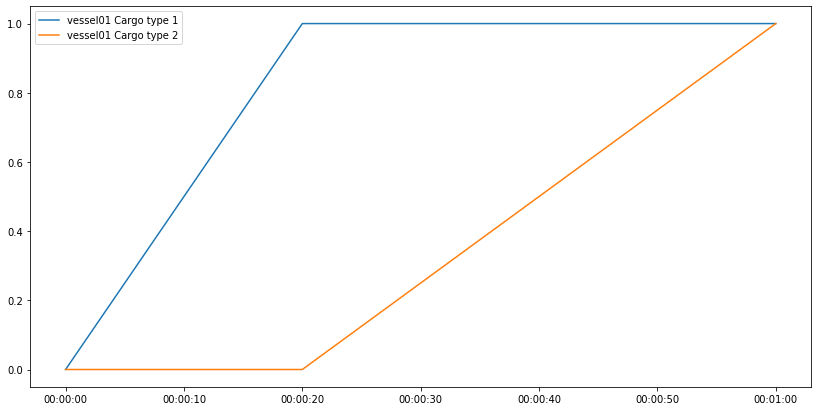

In [12]:
fig = plot.get_step_chart([vessel01])

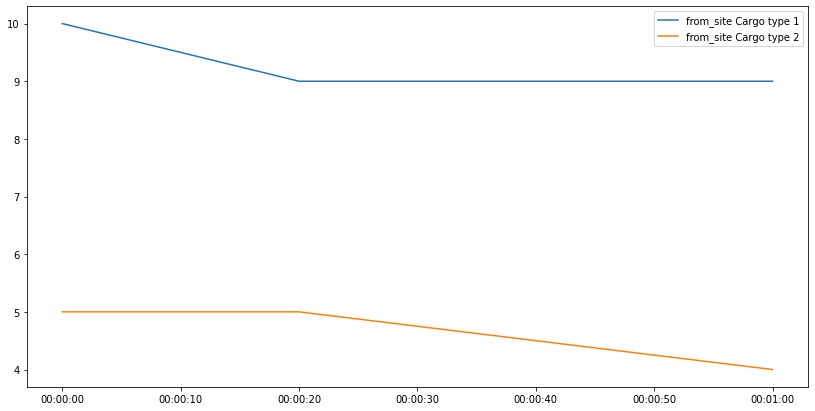

In [13]:
fig = plot.get_step_chart([from_site])

Observe that first 1 piece of 'Cargo type 1' is loaded from 'from_site' to 'vessel01'. This takes 20 time units. Next 1 piece of 'Cargo type 2' is loaded from 'from_site' to 'vessel01'. This takes 20 time units. 

The original stock of 'Cargo type 1' was 10, and it is reduced to 9 after 20 time units. The original stock of 'Cargo type 2' was 5, and it is reduced to 4 after 60 time units. 